In [25]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import os
import numpy as np
import json
import importlib

from transformers import AutoModel, AutoTokenizer
from transformers import PreTrainedTokenizer
from tensor2tensor.data_generators import text_encoder

In [13]:
# model = SentenceTransformer("sentence-transformers/LaBSE")  # multilingual incl. Latin

In [29]:
base_path = "/srv/models/latin-bert"

# Initialize the tokenizer with the vocab.txt file and the encoder
vocab_file_path = "/srv/models/latin-bert/vocab.txt" # "/Users/vojtechkase/Projects/latin-bert/models/latin_bert/vocab.txt"  # Update this path
subword_tokenizer_path = "/srv/models/latin-bert/latin.subword.encoder"
# Update this path
encoder = text_encoder.SubwordTextEncoder(subword_tokenizer_path)

spec = importlib.util.spec_from_file_location("latin_tokenizer", os.path.join(base_path, "latin_tokenizer.py"))
latin_tokenizer = importlib.util.module_from_spec(spec)
loader = importlib.util.LazyLoader(spec.loader)
spec.loader.exec_module(latin_tokenizer)

LatinTokenizer = latin_tokenizer.LatinTokenizer

tokenizer_labert = LatinTokenizer(vocab_file_path, encoder)
# model_labert = AutoModel.from_pretrained(base_path)

model_labert_wsd = AutoModel.from_pretrained(
    "../../labyrinth/data/models/latin-bert-wic-ft",
    output_hidden_states=True,
    output_attentions=False
)

In [28]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [41]:
print(list(lexeme_df.loc[lexeme_df["target_canonical"]=="mercurius metallorum"]["sense_def_all"].iloc[0]))

['Ist darauß die Natur der Coͤrper gezogen wirdt, die quinta essentia, & aqua permanens, spiritus, semen foemininum passiuum, das Badt ond Mutter deß Koͤnigs, die den Koͤnig zu sich ziehet / dann sie eine vnnd lieben sich.', 'mercurius corporis praecipitatus, mercurius corporalis, Wann die Metallen in ihr erste materiam bracht ond dann praecipitirt in ihm selbs.']


In [15]:
#lexeme_df["def_embeddings"] = lexeme_df.apply(lambda row: model.encode([row["target_canonical"] + ": " + str(sense_def) for sense_def in row["sense_def_all"]]), axis=1)

In [16]:
#emb_dir = "../data/large_files/emlap_hits_embs"
#os.makedirs(emb_dir, exist_ok=True)

In [17]:
#dir = "../data/large_files/emlap_ruland_instances"
#fname = "mercurius_metallorum.parquet"
#instances = pd.read_parquet(os.path.join(dir, fname)).to_dict("records")

In [22]:
instances = lexeme_df.loc[lexeme_df["target_canonical"] == "mercurius metallorum", "emlap_instances"].iloc[0]#%%

In [24]:
import embedding_helpers
importlib.reload(embedding_helpers)
from embedding_helpers import *

In [30]:
sample_instance = instances[0]

In [33]:
# compute embedding
result = embedding_helpers.embed_emlap_instance(
    instance=sample_instance,
    tokenizer=tokenizer_labert,
    model=model_labert_wsd,
    device="cuda",                # or "cpu"
    layer_idx=11,
    piece_pooling="mean",
    context_lemmatized=True,
    target_lemmatized=False,
    context_pos_filtered=True,
)

In [36]:
result["target_tokens"]

[{'char_end': 338,
  'char_start': 330,
  'lemma': 'mercurius',
  'pos': 'NOUN',
  'sentence_id': 'emlap_100007_1188',
  'token_id': 2096652,
  'token_text': 'mercurio'},
 {'char_end': 349,
  'char_start': 339,
  'lemma': 'metallum',
  'pos': 'NOUN',
  'sentence_id': 'emlap_100007_1188',
  'token_id': 2096653,
  'token_text': 'metallorum'}]

In [37]:
result["embedding"]

array([-4.00451362e-01,  1.33828056e+00, -3.04832160e-01,  1.66712254e-01,
       -2.44733840e-01, -1.52729675e-01, -1.40295818e-01, -1.34616137e-01,
       -1.56815559e-01, -7.13653803e-01,  5.17608583e-01,  4.53164756e-01,
       -3.69124055e-01, -3.84642810e-01, -3.96189451e-01,  3.46243680e-02,
        6.99264944e-01,  5.42940497e-01, -8.83286357e-01, -8.21097791e-02,
        4.78951901e-01, -7.58540571e-01, -4.32380557e-01,  7.25198984e-01,
        4.22471970e-01,  5.58088064e-01, -1.61657631e-01,  3.79452199e-01,
       -2.59831607e-01,  1.55952066e-01, -4.47754323e-01, -3.46653581e-01,
        3.43967497e-01, -8.13594937e-01, -1.89005792e-01, -5.23376018e-02,
       -4.51611370e-01, -1.23584911e-01,  1.20605826e-02,  7.68073797e-02,
        7.86347032e-01, -1.79065108e-01,  2.07856059e-01, -2.21835867e-01,
        7.06949294e-01, -7.92169333e-01, -7.18491226e-02, -4.82857078e-01,
        8.57359320e-02, -1.87310427e-01,  1.38785541e-01,  5.07395446e-01,
       -6.52644396e-01,  

In [53]:
def_embeddings = np.stack(lexeme_df[lexeme_df["target_canonical"]=="lapis philosophorum"]["def_embeddings"])[0]

In [24]:
instance_test = pd.read_parquet(os.path.join(dir, '01780_lapis_philosophorum.parquet')) # )# .to_dict(orient="records")
instance_test

,target_phrase,target_from,matched_by,grela_id,target_sentence_id,start_sentence_id,end_sentence_id,kwic_text,kwic_tokens,target_sentence_text,target_sentence_tokens
0,lapis philosophus,relemmatized,lemma,emlap_100002,emlap_100002_156,emlap_100002_156,emlap_100002_156,", aquarum tam uegetabilium quam mineralium ad ...","[{'token_id': 1383892, 'token_text': ',', 'lem...","Et cum hoc sufficit tibi modus generalis , aqu...","[{'token_id': 1383885, 'token_text': 'Et', 'le..."
1,lapis philosophus,relemmatized,lemma,emlap_100002,emlap_100002_672,emlap_100002_671,emlap_100002_672,quia ibi large continetur hec doctrina . PItem...,"[{'token_id': 1397417, 'token_text': 'quia', '...",PItem in compositione lapidis philosophorum ru...,"[{'token_id': 1397424, 'token_text': 'PItem', ..."
2,lapis philosophus,relemmatized,lemma,emlap_100002,emlap_100002_721,emlap_100002_719,emlap_100002_722,"& uirtutem sue nature . PQuestio . Pater , si ...","[{'token_id': 1398678, 'token_text': '&', 'lem...","Pater , si lapis philosophorum cadit in doctri...","[{'token_id': 1398685, 'token_text': 'Pater', ..."
3,lapis philosophus,relemmatized,lemma,emlap_100002,emlap_100002_722,emlap_100002_722,emlap_100002_722,"non solum ad preciosos lapides , sed et iam ad...","[{'token_id': 1398700, 'token_text': 'non', 'l...","Fili , hec regula non solum ad preciosos lapid...","[{'token_id': 1398696, 'token_text': 'Fili', '..."
4,lapis philosophus,relemmatized,lemma,emlap_100007,emlap_100007_356,emlap_100007_355,emlap_100007_357,operemur nisi in sole et Mercurio simuliunctis...,"[{'token_id': 2081304, 'token_text': 'operemur...",in quibus lapis philosophorum consistit .,"[{'token_id': 2081312, 'token_text': 'in', 'le..."
...,...,...,...,...,...,...,...,...,...,...,...
289,lapis philosophus,relemmatized,lemma,emlap_100073,emlap_100073_861,emlap_100073_861,emlap_100073_862,est non reperire ignem qui totam materiam conu...,"[{'token_id': 645972, 'token_text': 'est', 'le...",Error igitur istius artis est non reperire ign...,"[{'token_id': 645968, 'token_text': 'Error', '..."
290,lapis philosophus,relemmatized,lemma,emlap_100073,emlap_100073_921,emlap_100073_920,emlap_100073_923,quo securius quiescendo rubificatur . Hic est ...,"[{'token_id': 646717, 'token_text': 'quo', 'le...",Hic est iuxta uotum dictus Lapis PhilosoPhorum .,"[{'token_id': 646722, 'token_text': 'Hic', 'le..."
291,lapis philosophus,relemmatized,lemma,emlap_100074,emlap_100074_1425,emlap_100074_1425,emlap_100074_1426,"eo exspoliato sit generatum , & perfectum , er...","[{'token_id': 2141076, 'token_text': 'eo', 'le...","etiam ipsa corpora metallica , preter aurum , ...","[{'token_id': 2141033, 'token_text': 'etiam', ..."
292,lapis philosophus,relemmatized,lemma,emlap_100074,emlap_100074_1566,emlap_100074_1565,emlap_100074_1566,"nondum esset inceptum , quippe quia est necess...","[{'token_id': 2144342, 'token_text': 'nondum',...",ut lapis philosophorum elici possit de natura ...,"[{'token_id': 2144351, 'token_text': 'ut', 'le..."


In [26]:
kwic_texts = [d["kwic_text"] for d in instance_records]
embeddings = model.encode(kwic_texts)
meta = pd.DataFrame(
    {
        "row_index": np.arange(len(instance_records), dtype=np.int64),
        "kwic_text": [r.get("kwic_text", "") for r in instance_records],
    }
)

In [27]:
# np.save(os.path.join(emb_dir, "embeddings.npy", embeddings)

In [28]:
years = len(kwic_texts) * ["1500"]

In [29]:
import numpy as np
from typing import Optional, Sequence
from sklearn.manifold import TSNE
import plotly.graph_objects as go

def tsne_plot_3d_by_year(
    embeddings: np.ndarray,
    years: Sequence[float | int],
    *,
    colors: Optional[Sequence] = None,        # e.g. a list of color strings or numeric for colorscale
    hover_text: Optional[Sequence[str]] = None,
    title: str = "t-SNE by Year",
    perplexity: float = 30.0,
    learning_rate: float = 200.0,
    n_iter: int = 1000,
    random_state: int = 42,
    max_points: Optional[int] = None,         # e.g. 5000 for speed; None = use all
    width: int = 1000,
    height: int = 800,
):
    """
    - Runs 2D t-SNE on `embeddings`.
    - Plots a 3D scatter: x=years, y/z = t-SNE dims.
    - If colors not provided, uses years with a colorscale.
    - If hover_text not provided, shows 'year: <year>' by default.
    """
    assert embeddings.ndim == 2, "embeddings must be 2D [n_samples, n_dims]"
    n = embeddings.shape[0]
    assert len(years) == n, "len(years) must match embeddings.shape[0]"
    if colors is not None:
        assert len(colors) == n, "len(colors) must match embeddings.shape[0]"
    if hover_text is not None:
        assert len(hover_text) == n, "len(hover_text) must match embeddings.shape[0]"

    # Optional downsampling
    if max_points is not None and n > max_points:
        rng = np.random.RandomState(random_state)
        idx = np.sort(rng.choice(n, size=max_points, replace=False))
        X = embeddings[idx]
        years_ds = np.asarray(years)[idx]
        colors_ds = np.asarray(colors)[idx] if colors is not None else None
        hover_ds = [hover_text[i] for i in idx] if hover_text is not None else None
    else:
        X = embeddings
        years_ds = np.asarray(years)
        colors_ds = np.asarray(colors) if colors is not None else None
        hover_ds = hover_text

    # Perplexity must be < n_samples
    eff_perp = min(perplexity, max(5, (len(X) - 1) // 3))
    tsne = TSNE(
        n_components=2,
        perplexity=eff_perp,
        learning_rate=learning_rate,
        max_iter=n_iter,
        init="pca",
        random_state=random_state,
        metric="euclidean",
        verbose=0,
    )
    X2 = tsne.fit_transform(X)

    # Build axes
    xs = years_ds
    ys = np.round(X2[:, 0], 2)
    zs = np.round(X2[:, 1], 2)

    # Fallbacks
    if hover_ds is None:
        hover_ds = [f"year: {int(y)}" for y in xs]
    # If no explicit colors, use year values with a colorscale
    marker_kwargs = dict(size=5, opacity=0.8)
    if colors_ds is not None:
        marker_kwargs["color"] = colors_ds
    else:
        marker_kwargs["color"] = xs
        marker_kwargs["colorscale"] = "Viridis"
        marker_kwargs["showscale"] = True

    fig = go.Figure(
        data=go.Scatter3d(
            x=xs,
            y=ys,
            z=zs,
            mode="markers",
            marker=marker_kwargs,
            text=hover_ds,
            hoverinfo="text",
        )
    )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="year", showbackground=False, showgrid=True, showline=True),
            yaxis=dict(title="", showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor="rgba(0,0,0,0)", showbackground=False),
            zaxis=dict(title="", showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor="rgba(0,0,0,0)", showbackground=False),
            bgcolor="rgba(255,255,255,0)",
        ),
        paper_bgcolor="rgba(255,255,255,255)",
        plot_bgcolor="rgba(255,255,255,255)",
        autosize=False,
        width=width,
        height=height,
        margin=dict(l=0, r=0, b=0, t=0),
    )
    return fig

In [50]:
def_embeddings = np.stack(lexeme_df[lexeme_df["target_canonical"]=="lapis philosophorum"]["def_embeddings"])[0]

In [51]:
np.vstack([def_embeddings, embeddings])

array([[-0.04252436,  0.00970485, -0.04152936, ...,  0.01387948,
        -0.02828567,  0.03160987],
       [-0.02013145,  0.00254185, -0.0738183 , ...,  0.01403286,
        -0.033834  ,  0.06567452],
       [-0.02288366, -0.02218054, -0.04603389, ..., -0.02119105,
        -0.02521566, -0.00384336],
       ...,
       [-0.01067799, -0.02210889, -0.05638698, ...,  0.00665592,
         0.01055581,  0.02949727],
       [ 0.02949439, -0.00157743, -0.06340731, ..., -0.01948354,
         0.0292315 ,  0.04681293],
       [-0.05550234,  0.02722427, -0.05673807, ...,  0.04406148,
         0.08124747,  0.01711899]], shape=(295, 768), dtype=float32)

In [52]:
import numpy as np

# def_embeddings: shape (N_def, d)
# embeddings:     shape (N_inst, d)
# years:          length N_inst (years for instances)
# senses_defs:    length N_def (hover text for definitions)
# kwic_texts:     length N_inst (hover text for instances)

N_def  = len(def_embeddings)
N_inst = len(embeddings)

# 1) Concatenate embeddings for a single t-SNE fit
X_all = np.vstack([def_embeddings, embeddings])   # shape (N_def + N_inst, d)

# 2) Build years for both groups:
#    Definitions usually have no year → park them just to the left of your timeline.
#    You can change this to any constant or per-definition year if you have it.
year_anchor = int(np.min(years)) - 1
years_defs  = np.full(N_def, year_anchor, dtype=int)
years_all   = np.concatenate([years_defs, np.asarray(years)])

# 3) Colors and hover text
colors_all = (["green"] * N_def) + (["red"] * N_inst)
hover_all  = list(["example def"]) + list(kwic_texts)

# 4) Plot
title = f"Definitions (green) vs instances (red): 'mercurius' (N_defs={N_def}, N_inst={N_inst})"
fig = tsne_plot_3d_by_year(
    embeddings=X_all,              # run t-SNE on the combined set
    years=years_all,               # x-axis: defs at a fixed 'anchor' year
    colors=colors_all,
    hover_text=hover_all,
    title=title,
    perplexity=30,
    n_iter=1000,
    max_points=None,
)
fig.show()

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U4')) -> None

In [30]:
# After computing tsne:
fig = tsne_plot_3d_by_year(
    embeddings=[def_embeddings] + embeddings,             # your original high-dim vectors (t-SNE is run inside)
    years=years,                       # your provided array/list
    colors=["red"] * len(embeddings),                     # optional
    hover_text=kwic_texts,             # optional
    title=f"Sentences with 'mercurius' (N={len(kwic_texts)})",
    perplexity=30,
    n_iter=1000,
    max_points=None,                   # or e.g. 5000 for speed
)
fig.show()

In [46]:
# ---- 2) PLOT 2D t-SNE ----
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_2d(
    embeddings: np.ndarray,
    labels: list[str] | None = None,
    perplexity: float = 30.0,
    learning_rate: float = 200.0,
    n_iter: int = 1000,
    random_state: int = 42,
    max_points: int | None = 5000,   # downsample large sets for speed
    save_path: str | None = None,
):
    """
    Reduce embeddings to 2D with t-SNE and make a single scatter plot.
    - Uses matplotlib, one plot, no explicit colors.
    - Optionally down-samples to `max_points` for speed.
    - If `labels` provided and len<=200, annotates points (keeps plot readable).
    """
    X = embeddings
    if max_points is not None and len(X) > max_points:
        idx = np.random.RandomState(random_state).choice(len(X), size=max_points, replace=False)
        X = X[idx]
        labels = [labels[i] for i in idx] if labels is not None else None

    # t-SNE requires perplexity < n_samples
    effective_perplexity = min(perplexity, max(5, (len(X) - 1) // 3))
    tsne = TSNE(
        n_components=2,
        perplexity=effective_perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        init="pca",
        random_state=random_state,
        metric="euclidean",
        verbose=1,
    )
    X2 = tsne.fit_transform(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:, 0], X2[:, 1], s=8)  # no color specified
    plt.title("t-SNE (2D)")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")

    # label only small sets to avoid unreadable clutter
    if labels is not None and len(labels) <= 200:
        for (x, y, text) in zip(X2[:, 0], X2[:, 1], labels):
            plt.annotate(str(text)[:60], (x, y), fontsize=6, xytext=(2, 2), textcoords="offset points")

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

/home/jupyter-vojta/notebooks/labyrinth/venv_torch_nlp/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1422 samples in 0.001s...
[t-SNE] Computed neighbors for 1422 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1422
[t-SNE] Computed conditional probabilities for sample 1422 / 1422
[t-SNE] Mean sigma: 0.259410
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.337601
[t-SNE] KL divergence after 1000 iterations: 2.009509


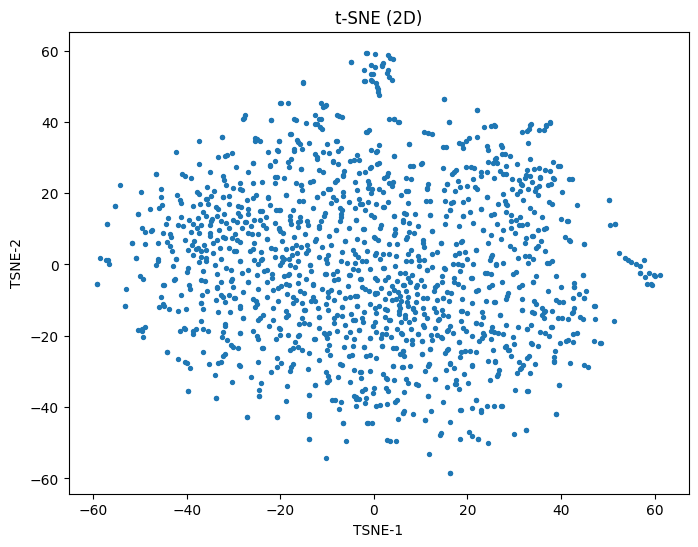

In [49]:

plot_tsne_2d(embeddings, labels=kwic_texts, perplexity=30, n_iter=1000)